## **Data Analysis**

This notebook presents the initial data analysis that based our project. 

The goal was to understand the data domain correctly, as well as our data main characteristics. 

In [2]:
import pandas as pd
import pgmpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import (
    MaximumLikelihoodEstimator,
    BayesianEstimator,
    ExpectationMaximization,
)

from pgmpy.inference import VariableElimination
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

/Users/sarataboas/.pyenv/versions/tsi-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Exploratory Data Analysis**

Exploratory Data Analysis includes, for each dataset:
- Individual analysis of each dataset main characteristics.
- 

### Sensors

Data observed in each sensor:
- Temperature
- Vibration
- Coolant Flow 
- ...


In [3]:
telemetry_data = pd.read_csv('data/telemetry.csv')
print("telemetry_data Shape: ", telemetry_data.shape)
telemetry_data.head()

telemetry_data Shape:  (103680, 11)


,timestamp,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear
0,2025-01-01T00:00:00,M-A,73.96,24.36,0.871,1.050,0.9,3600,0.294,3.193,0.000
1,2025-01-01T00:05:00,M-A,53.38,22.87,0.536,1.083,1.3,800,0.329,2.149,0.000
2,2025-01-01T00:10:00,M-A,58.12,24.59,0.455,1.025,0.9,1200,0.369,2.457,0.001
3,2025-01-01T00:15:00,M-A,58.08,23.05,0.680,0.977,0.7,1200,0.479,2.702,0.001
4,2025-01-01T00:20:00,M-A,55.37,24.28,0.663,1.072,1.1,800,0.328,2.148,0.001


Missing values in telemetry_data.

In [4]:
for col in telemetry_data.columns:
    missing_count = telemetry_data[col].isnull().sum()
    if missing_count > 0:
        print(f"Column '{col}' has {missing_count} missing values.")

Column data types in telemetry_data.

In [5]:
telemetry_data_types = pd.DataFrame(telemetry_data.dtypes, columns=['Data Type'])
telemetry_data_types

,Data Type
timestamp,object
machine_id,object
spindle_temp,float64
ambient_temp,float64
vibration_rms,float64
coolant_flow,float64
feed_rate,float64
spindle_speed,int64
load_pct,float64
power_kw,float64


**Sensor readings distribution** 

Statistical analysis and distributions for each numerical sensor.

In [6]:
numeric_cols = telemetry_data.select_dtypes(include=[np.number]).columns
telemetry_data[numeric_cols].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
spindle_temp,103680.0,68.136173,6.431063,50.080,58.75000,63.3175,67.220,72.580,79.630,88.620
ambient_temp,103680.0,22.001607,4.429376,12.170,15.34000,17.9800,21.995,26.020,28.690,31.860
vibration_rms,103680.0,0.984043,0.185500,0.364,0.66900,0.8630,0.973,1.111,1.303,1.536
coolant_flow,103680.0,0.532744,0.158853,0.200,0.36200,0.4280,0.481,0.581,0.884,1.200
feed_rate,103680.0,1.040546,0.250903,0.700,0.70000,0.9000,1.100,1.300,1.500,1.500
spindle_speed,103680.0,1849.834105,896.620676,800.000,800.00000,1200.0000,2000.000,2800.000,3600.000,3600.000
load_pct,103680.0,0.512752,0.201694,0.050,0.20100,0.3550,0.503,0.666,0.849,1.000
power_kw,103680.0,3.343900,0.858452,1.690,2.32295,2.6430,3.138,3.896,5.012,6.881
tool_wear,103680.0,0.952667,0.171522,0.000,0.52700,1.0000,1.000,1.000,1.000,1.000


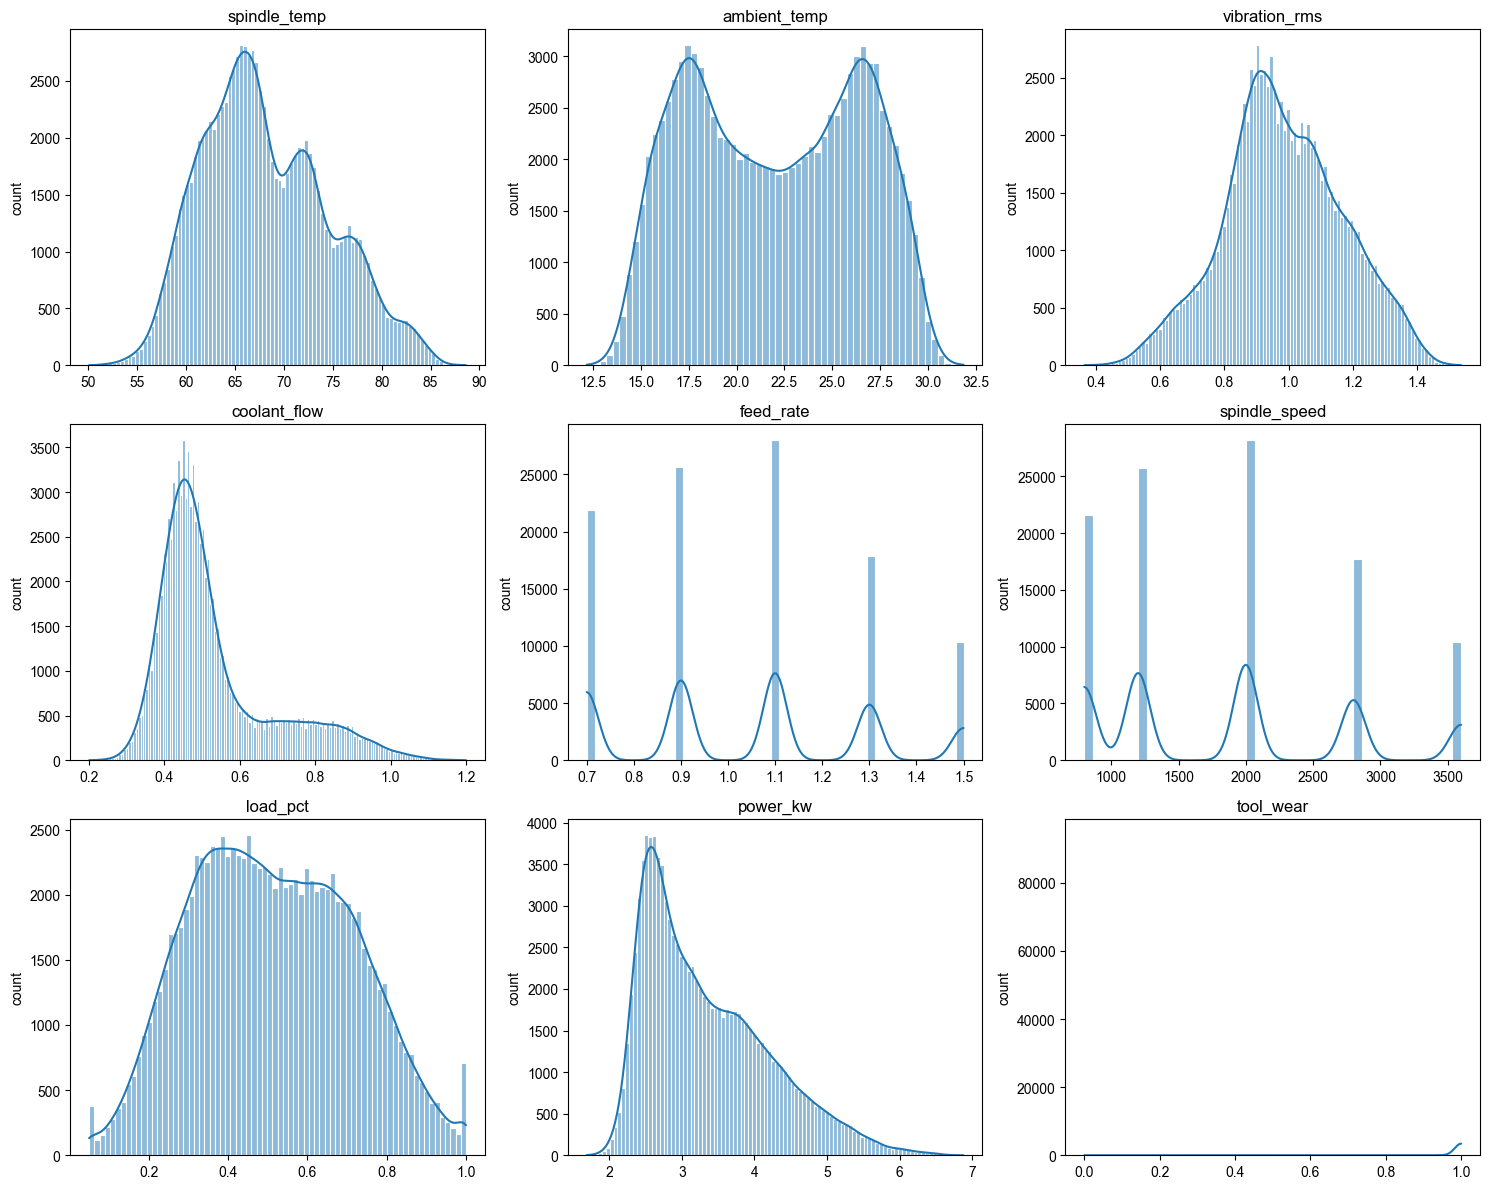

In [7]:
numeric_cols = telemetry_data.select_dtypes(include=[np.number]).columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

sns.set_style('whitegrid')
for ax, col in zip(axes, numeric_cols):
    sns.histplot(telemetry_data[col], kde=True, ax=ax, color='#1f77b4', edgecolor='white', linewidth=0.8)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('count')

for ax in axes[len(numeric_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

The temperature of the Spingle seems to be mixture of 3 Gaussian Models, while the temperature of the ambiente seems to be a mixture of 2 Gaussian models. 

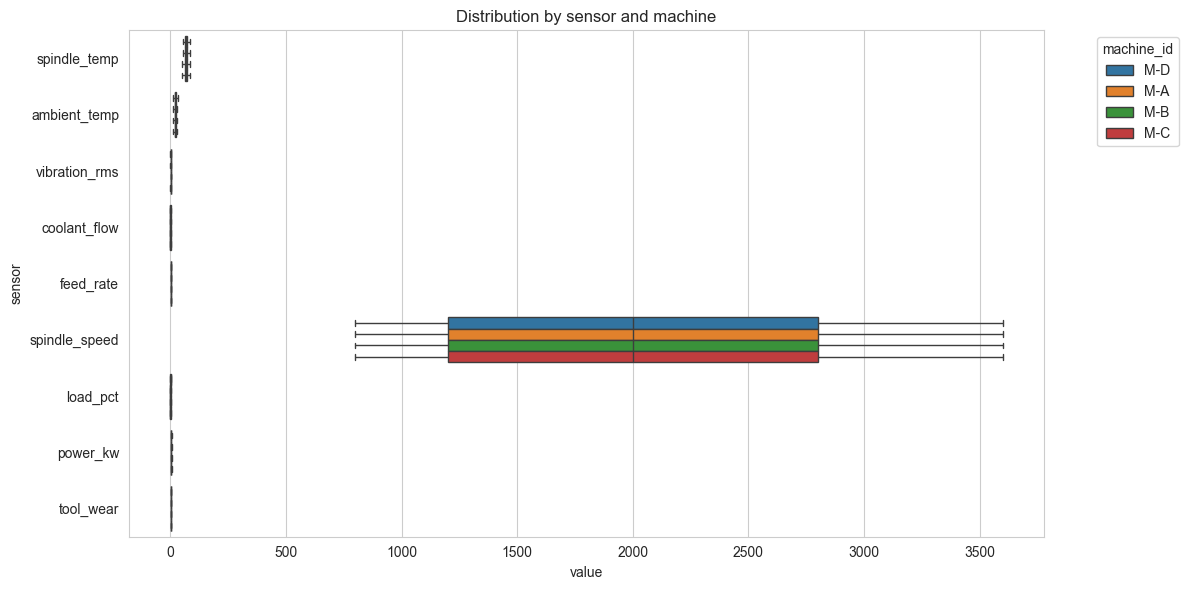

In [8]:
numeric_cols = telemetry_data.select_dtypes(include=[np.number]).columns

# Reduced sample for better visualization
plot_sample = telemetry_data.sample(5000, random_state=42) if len(telemetry_data) > 5000 else telemetry_data
melted = plot_sample.melt(id_vars='machine_id', value_vars=numeric_cols, var_name='sensor', value_name='value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x='value', y='sensor', hue='machine_id', showfliers=False)
plt.title('Distribution by sensor and machine')
plt.xlabel('value')
plt.ylabel('sensor')
plt.legend(title='machine_id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Here, we can see that the values taken from each machine are not very distant from each other.

### Labels

In [9]:
labels_data = pd.read_csv('data/labels.csv')
print("labels_data Shape: ", labels_data.shape)
labels_data.head()

labels_data Shape:  (103680, 3)


,timestamp,machine_id,spindle_overheat
0,2025-01-01T00:00:00,M-A,0
1,2025-01-01T00:05:00,M-A,0
2,2025-01-01T00:10:00,M-A,0
3,2025-01-01T00:15:00,M-A,0
4,2025-01-01T00:20:00,M-A,0


Column data types in labels_data.

In [10]:
labels_data_types = pd.DataFrame(labels_data.dtypes, columns=['Data Type'])
labels_data_types

,Data Type
timestamp,object
machine_id,object
spindle_overheat,int64


Missing / Unique Values

In [11]:
for col in labels_data.columns:
    unique_values = labels_data[col].nunique()
    missing_count = labels_data[col].isnull().sum()
    print(f"Column '{col}' has {unique_values} unique values and {missing_count} missing values.")

Column 'timestamp' has 25920 unique values and 0 missing values.
Column 'machine_id' has 4 unique values and 0 missing values.
Column 'spindle_overheat' has 1 unique values and 0 missing values.


Global count

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


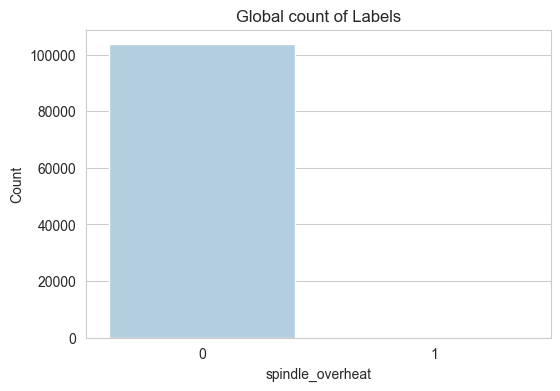

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
# global count
sns.countplot(data=labels_data, x='spindle_overheat', order=[0, 1], palette='Blues', ax=ax)
_ = ax.set_title('Global count of Labels')
_ = ax.set_xlabel('spindle_overheat')
_ = ax.set_ylabel('Count')



### Maintenence

In [13]:
maintenance_data = pd.read_csv('data/maintenance.csv') 
print("Maintenence_data Shape: ", maintenance_data.shape)
maintenance_data.head()

Maintenence_data Shape:  (23, 5)


,timestamp,machine_id,action_type,duration_h,success
0,2025-01-12T00:00:00,M-C,clean_filter,1.5,1
1,2025-01-13T00:00:00,M-A,replace_bearing,4.0,1
2,2025-01-14T00:00:00,M-B,clean_filter,1.5,1
3,2025-01-15T00:00:00,M-D,replace_bearing,4.0,1
4,2025-01-27T00:00:00,M-B,clean_filter,1.5,1


Missing / Unique Values

In [14]:
for col in maintenance_data.columns:
    unique_values = maintenance_data[col].nunique()
    missing_count = maintenance_data[col].isnull().sum()
    print(f"Column '{col}' has {unique_values} unique values and {missing_count} missing values.")

Column 'timestamp' has 21 unique values and 0 missing values.
Column 'machine_id' has 4 unique values and 0 missing values.
Column 'action_type' has 4 unique values and 0 missing values.
Column 'duration_h' has 4 unique values and 0 missing values.
Column 'success' has 1 unique values and 0 missing values.


Column data types in maintenence_data.

In [15]:
maintenance_data_types = pd.DataFrame(maintenance_data.dtypes, columns=['Data Type'])
maintenance_data_types

,Data Type
timestamp,object
machine_id,object
action_type,object
duration_h,float64
success,int64


For Discrete Bayesian Network (with categorical nodes), we do not need to apply encoding techniques. Therefore, we continue with 'action_type' as a categorical variable of 4 states. 

### Components

Components data include components.csv, symptoms.csv, relations.csv and procedures.csv.

1. **Components.csv**

In [16]:
components_data = pd.read_csv('data/components.csv')
print("Components_data Shape: ", components_data.shape)
components_data.head()

Components_data Shape:  (5, 4)


,component_id,name,parent_component,function
0,C1,Spindle,NaN,Rotate tool
1,C2,CoolingSystem,NaN,Dissipate heat
2,C3,Fan,C2,Air flow
3,C4,Filter,C2,Filter coolant/air
4,C5,Bearing,C1,Support rotation


Missing / Unique Values

In [17]:
for col in components_data.columns:
    unique_values = components_data[col].nunique()
    missing_count = components_data[col].isnull().sum()
    print(f"Column '{col}' has {unique_values} unique values and {missing_count} missing values.")

Column 'component_id' has 5 unique values and 0 missing values.
Column 'name' has 5 unique values and 0 missing values.
Column 'parent_component' has 2 unique values and 2 missing values.
Column 'function' has 5 unique values and 0 missing values.


Column data types in components_data.

In [18]:
components_data_types = pd.DataFrame(components_data.dtypes, columns=['Data Type'])
components_data_types

,Data Type
component_id,object
name,object
parent_component,object
function,object


2. **Symptoms.csv**

In [19]:
symptoms_data = pd.read_csv('data/symptoms.csv')
print("Symptoms_data Shape: ", components_data.shape)
symptoms_data.head()

Symptoms_data Shape:  (5, 4)


,symptom_id,name
0,S1,HighVibration
1,S2,HighSpindleTemp
2,S3,LowCoolantFlow


Missing / Unique Values

In [20]:
for col in symptoms_data.columns:
    unique_values = symptoms_data[col].nunique()
    missing_count = symptoms_data[col].isnull().sum()
    print(f"Column '{col}' has {unique_values} unique values and {missing_count} missing values.")

Column 'symptom_id' has 3 unique values and 0 missing values.
Column 'name' has 3 unique values and 0 missing values.


Column data types in symptoms_data.

In [21]:
symptoms_data_types = pd.DataFrame(symptoms_data.dtypes, columns=['Data Type'])
symptoms_data_types

,Data Type
symptom_id,object
name,object


3. **Relations.csv**

In [22]:
relations_data = pd.read_csv('data/relations.csv')   
print("Relations_data Shape: ", relations_data.shape)   
relations_data

Relations_data Shape:  (8, 3)


,subj,pred,obj
0,BearingWearHigh,causesSymptom,HighVibration
1,BearingWearHigh,affectsComponent,Bearing
2,FanFault,causesSymptom,HighSpindleTemp
3,FanFault,affectsComponent,Fan
4,CloggedFilter,causesSymptom,LowCoolantFlow
5,CloggedFilter,affectsComponent,Filter
6,LowCoolingEfficiency,causesSymptom,HighSpindleTemp
7,LowCoolingEfficiency,affectsComponent,CoolingSystem


Missing / Unique Values

In [23]:
for col in relations_data.columns:
    unique_values = relations_data[col].nunique()
    missing_count = relations_data[col].isnull().sum()
    print(f"Column '{col}' has {unique_values} unique values and {missing_count} missing values.")

Column 'subj' has 4 unique values and 0 missing values.
Column 'pred' has 2 unique values and 0 missing values.
Column 'obj' has 7 unique values and 0 missing values.


Column data types in relations_data.

In [24]:
relations_data_types = pd.DataFrame(relations_data.dtypes, columns=['Data Type'])
relations_data_types

,Data Type
subj,object
pred,object
obj,object


4. **Procedures.csv**

In [25]:
procedures_data = pd.read_csv('data/procedures.csv')      
print("Procedures_data Shape: ", procedures_data.shape)
procedures_data.head()

Procedures_data Shape:  (4, 7)


,proc_id,name,targets_component,mitigates_cause,effort_h,spare_parts_cost_eur,risk_rating
0,P1,ReplaceBearing,Bearing,BearingWearHigh,6.0,600,3
1,P2,RepairFan,Fan,FanFault,2.0,150,2
2,P3,CleanFilter,Filter,CloggedFilter,1.5,50,1
3,P4,FlushCoolant,CoolingSystem,LowCoolingEfficiency,2.0,90,2


Missing / Unique Values

In [26]:
for col in procedures_data.columns:
    unique_values = procedures_data[col].nunique()
    missing_count = procedures_data[col].isnull().sum()
    print(f"Column '{col}' has {unique_values} unique values and {missing_count} missing values.")

Column 'proc_id' has 4 unique values and 0 missing values.
Column 'name' has 4 unique values and 0 missing values.
Column 'targets_component' has 4 unique values and 0 missing values.
Column 'mitigates_cause' has 4 unique values and 0 missing values.
Column 'effort_h' has 3 unique values and 0 missing values.
Column 'spare_parts_cost_eur' has 4 unique values and 0 missing values.
Column 'risk_rating' has 3 unique values and 0 missing values.


Column data types in relations_data.

In [27]:
procedures_data_types = pd.DataFrame(procedures_data.dtypes, columns=['Data Type'])
procedures_data_types 

,Data Type
proc_id,object
name,object
targets_component,object
mitigates_cause,object
effort_h,float64
spare_parts_cost_eur,int64
risk_rating,int64


## **Maintenance and Sensors Time Evolution**

In this section we analyze the how maintenance procedures happen through time and the evolution of the sensors' values, aggregated by day.

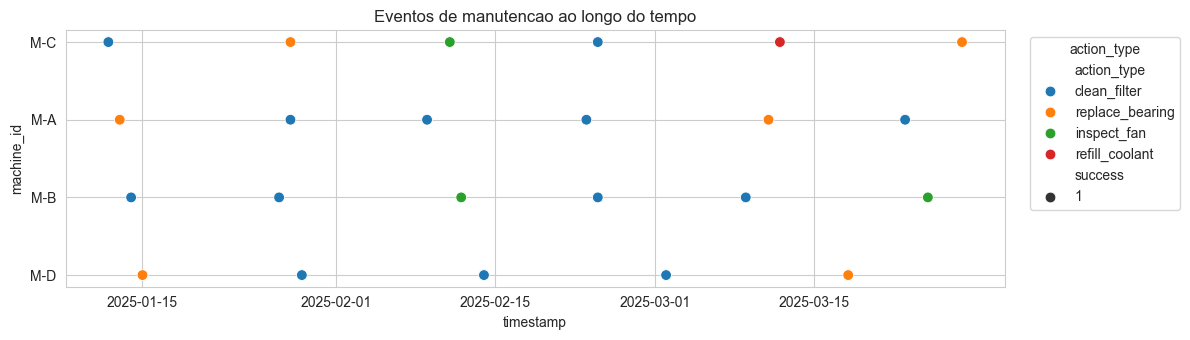

In [28]:
telemetry_ts = telemetry_data.copy()
telemetry_ts['timestamp'] = pd.to_datetime(telemetry_ts['timestamp'])
maintenance_ts = maintenance_data.copy()
maintenance_ts['timestamp'] = pd.to_datetime(maintenance_ts['timestamp'])

plt.figure(figsize=(12, 3.5))
sns.scatterplot(
    data=maintenance_ts, x='timestamp', y='machine_id',
    hue='action_type', style='success', s=60
)
plt.title('Eventos de manutencao ao longo do tempo')
plt.xlabel('timestamp')
plt.ylabel('machine_id')
plt.legend(title='action_type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### **Spindle Temperature evolution through time with Maintenance procedures**
Daily sinal `spindle_temp` by machine. The representations identify vertical lines in maintenance days.

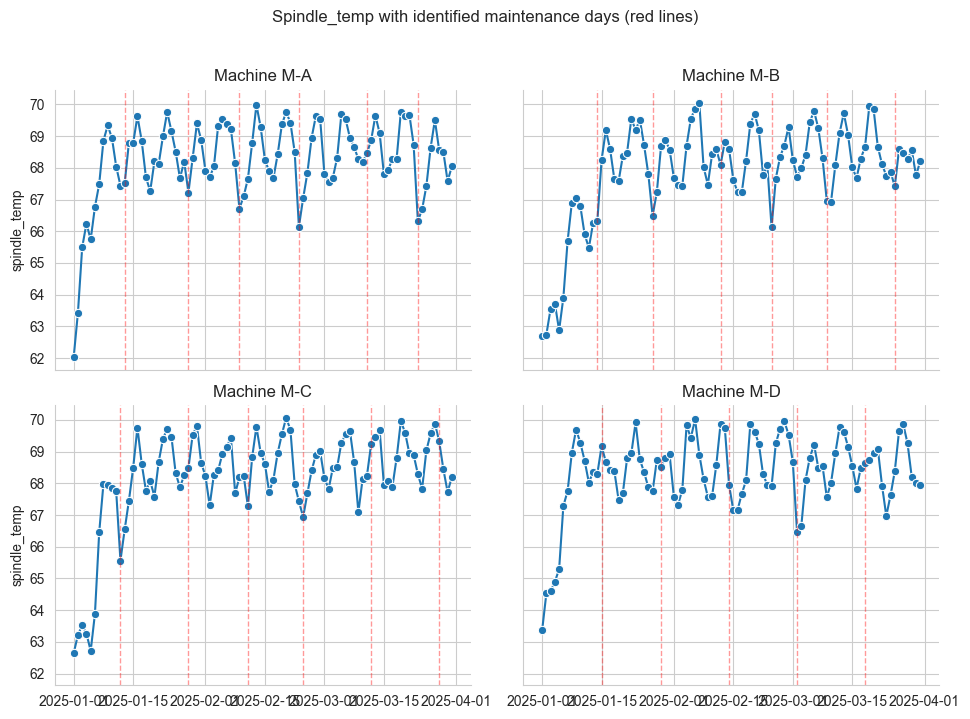

In [29]:
telemetry_ts = telemetry_data.copy()
telemetry_ts['timestamp'] = pd.to_datetime(telemetry_ts['timestamp'])
maintenance_ts = maintenance_data.copy()
maintenance_ts['timestamp'] = pd.to_datetime(maintenance_ts['timestamp'])

daily_temp = (telemetry_ts
    .set_index('timestamp')
    .groupby('machine_id')['spindle_temp']
    .resample('D')
    .mean()
    .reset_index()
)

maint_dates = {m: sorted(df['timestamp'].dt.normalize().unique()) for m, df in maintenance_ts.groupby('machine_id')}

g = sns.relplot(
    data=daily_temp, x='timestamp', y='spindle_temp',
    col='machine_id', col_wrap=2, kind='line', marker='o', height=3.5, aspect=1.4
)

for ax, machine in zip(g.axes.flatten(), g.col_names):
    for d in maint_dates.get(machine, []):
        ax.axvline(d, color='red', linestyle='--', alpha=0.4, linewidth=1)
    ax.set_xlabel('')
    ax.set_ylabel('spindle_temp')
    ax.set_title(f'Machine {machine}')

g.fig.suptitle('Spindle_temp with identified maintenance days (red lines)', y=1.02)
plt.tight_layout()
plt.show()

#### **Spindle Temperature evolution through time with Maintenance procedures by procedure type**
We added to the previous plot the visualization of the type of maintenence procedure- *action_type* - represented by the different coloured dots.

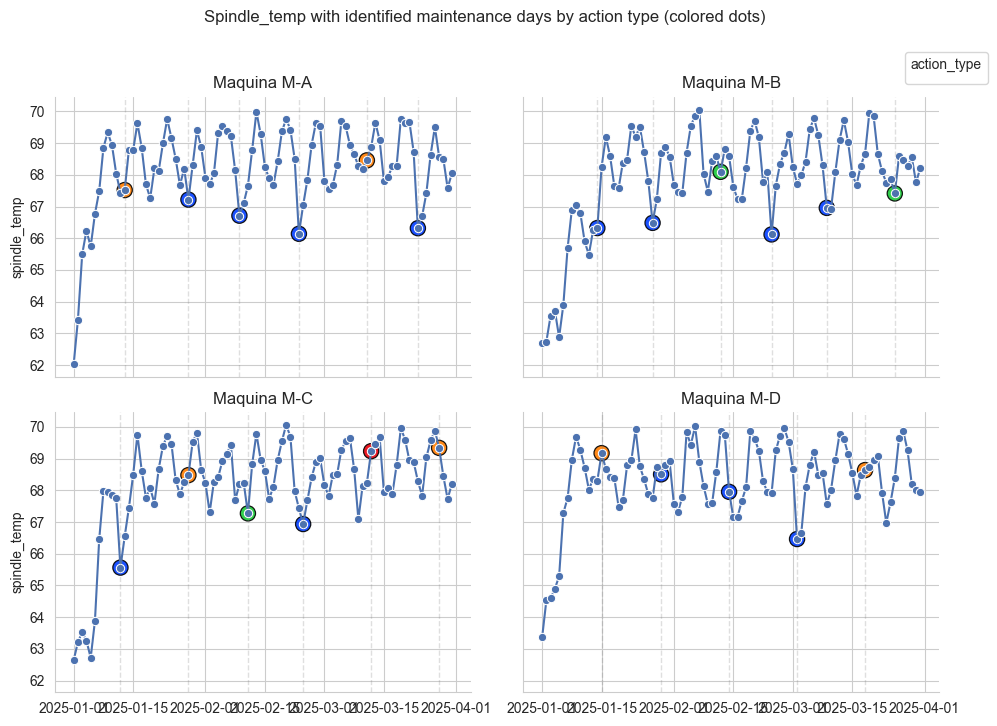

In [30]:
telemetry_ts = telemetry_data.copy()
telemetry_ts['timestamp'] = pd.to_datetime(telemetry_ts['timestamp'])
telemetry_ts['day'] = telemetry_ts['timestamp'].dt.normalize()
maintenance_ts = maintenance_data.copy()
maintenance_ts['timestamp'] = pd.to_datetime(maintenance_ts['timestamp'])
maintenance_ts['day'] = maintenance_ts['timestamp'].dt.normalize()

daily_temp = (
    telemetry_ts
    .groupby(['machine_id', 'day'])['spindle_temp']
    .mean()
    .reset_index()
    .rename(columns={'day': 'timestamp'})
)

maint_plot = maintenance_ts.merge(
    daily_temp.rename(columns={'timestamp': 'day'}),
    on=['machine_id', 'day'],
    how='left'
)

palette = dict(zip(
    maintenance_ts['action_type'].unique(),
    sns.color_palette('bright', n_colors=maintenance_ts['action_type'].nunique())
))

g = sns.relplot(
    data=daily_temp, x='timestamp', y='spindle_temp',
    col='machine_id', col_wrap=2, kind='line', marker='o',
    height=3.5, aspect=1.4, color='#4c72b0'
)

grid_axes = g.axes.flatten()
for ax, machine in zip(grid_axes, g.col_names):
    sub = maint_plot[maint_plot['machine_id'] == machine]
    sns.scatterplot(
        data=sub,
        x='day', y='spindle_temp', hue='action_type', palette=palette,
        s=120, edgecolor='black', linewidth=0.9, ax=ax, legend=False, alpha=0.9
    )
    ax.set_xlabel('')
    ax.set_ylabel('spindle_temp')
    ax.set_title(f'Maquina {machine}')
    for d in sub['day'].unique():
        ax.axvline(d, color='grey', linestyle='--', alpha=0.25, linewidth=1)


handles, labels = grid_axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, title='action_type', bbox_to_anchor=(1.02, 0.98))

g.fig.suptitle('Spindle_temp with identified maintenance days by action type (colored dots)', y=1.03)
plt.tight_layout()
plt.show()


#### **Spindle Temperature distribution in Maintenence Days**

Visualization of *spindle_temp* distribution (boxplots) in maintance days. We created several boxplots, according to the action type.

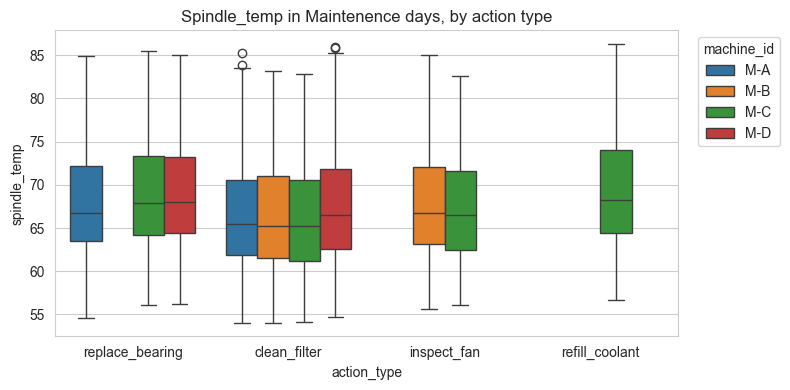

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

telemetry_ts = telemetry_data.copy()
telemetry_ts['timestamp'] = pd.to_datetime(telemetry_ts['timestamp'])
telemetry_ts['day'] = telemetry_ts['timestamp'].dt.normalize()
maintenance_ts = maintenance_data.copy()
maintenance_ts['timestamp'] = pd.to_datetime(maintenance_ts['timestamp'])
maintenance_ts['day'] = maintenance_ts['timestamp'].dt.normalize()

maint_days_temp = telemetry_ts.merge(
    maintenance_ts[['machine_id', 'day', 'action_type']],
    on=['machine_id', 'day'],
    how='inner'
)

plt.figure(figsize=(8, 4))
sns.boxplot(data=maint_days_temp, x='action_type', y='spindle_temp', hue='machine_id')
plt.title('Spindle_temp in Maintenence days, by action type')
plt.xlabel('action_type')
plt.ylabel('spindle_temp')
plt.legend(title='machine_id', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()